# 事前準備

In [1]:
# ライブラリのインポート
import os
import re
import random
from glob import glob
from warnings import filterwarnings

import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from collections import defaultdict

filterwarnings('ignore')   # warningをオフにする

In [2]:
# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# デバイスの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化
print(f'デバイス：{device}')

デバイス：cpu


In [4]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--image_size', type=int, default=224)
parser.add_argument('--num_classes', type=int, default=2)
opt = parser.parse_args(args=[])
print(opt)

Namespace(image_size=224, num_classes=2)


In [5]:
# NORMALのtestデータのディレクトリ
test_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/'

# PNEUMONIAのtestデータのディレクトリ
test_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/'

# 学習済みパラメータの読み込み

In [6]:
# モデルのパス
model_path = '../input/chest-xray-training-mobilenetv3l-final/mobilenet_v3_large.pth'


In [7]:
model = models.mobilenet_v3_large()
fc_in_features = model.classifier[0].out_features # 最終レイヤー関数の次元数
model.classifier[3] = nn.Linear(fc_in_features, opt.num_classes) # 最終レイヤー関数の付け替え
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

In [8]:
# 学習済みモデルの読み込み
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) # 学習済みモデルの読み込み

<All keys matched successfully>

In [9]:
# モデルをGPUに送る
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# transform

In [10]:
# 両サイドを10%切り取るクラス
class SideCrop():
    def __call__(self, image):
        w, h = image.size
        w1 = 0.05 * w
        h1 = 0.05 * h
        image_crop = image.crop((w1, 0, w-w1, h)) # (left, upper, right, lower)
        return image_crop

In [11]:
# transformの設定
transform = {
    'train': transforms.Compose([
        SideCrop(),
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        SideCrop(),
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

In [12]:
# Datasetの設定
class XrayDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, transform=None, phase=None):
        self.image_name_list = image_name_list # 画像ファイル名
        self.label_list = label_list # ラベル
        self.img_dir = img_dir # 画像データのディレクトリ
        self.phase = phase # 変数phaseで学習(train)もしくは検証(val)の設定を行う
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list) # 1エポックあたりに読み込むデータ数として、入力データの数を指定

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        image_path = os.path.join(self.img_dir, self.image_name_list[index]) # train_master.iloc[index, 0]はファイル名を抽出
        img = Image.open(image_path).convert('RGB')
        img = self.transform[self.phase](img)
        
        # index番目のラベルを取得する
        label = self.label_list[index]
        
        return img, label

# NORMALのテストデータを推論

## NORMALのテストデータのデータフレーム化

In [13]:
# ディレクトリ内の画像リスト作成
normal = glob(test_normal_dir+'*.jpeg')

In [14]:
# テストデータのリストを作成
test_file_list = []

for path in normal:
    file_name = re.split('[////////]', path)[8]
    test_file_list.append(file_name)
    #print(file_name)

In [15]:
# ファイル名とラベルのデータフレームを作成
test_normal_df = pd.DataFrame({'name':test_file_list})
test_normal_df['label'] = None

print(test_normal_df)
print(len(test_normal_df))

                          name label
0    NORMAL2-IM-0336-0001.jpeg  None
1            IM-0101-0001.jpeg  None
2    NORMAL2-IM-0337-0001.jpeg  None
3    NORMAL2-IM-0198-0001.jpeg  None
4            IM-0013-0001.jpeg  None
..                         ...   ...
229  NORMAL2-IM-0338-0001.jpeg  None
230  NORMAL2-IM-0195-0001.jpeg  None
231  NORMAL2-IM-0333-0001.jpeg  None
232  NORMAL2-IM-0150-0001.jpeg  None
233          IM-0010-0001.jpeg  None

[234 rows x 2 columns]
234


In [16]:
# 画像データの名前リストの抽出
x_test_normal = test_normal_df['name'].values
dummy = test_normal_df['name'].values
#print(x_test_normal, f'データ数：{len(x_test_normal)}')

In [17]:
# Datasetのインスタンス作成
test_normal_dataset = XrayDataset(x_test_normal, dummy, test_normal_dir, transform=transform, phase='val')

In [18]:
# DataLoader
test_normal_dataloader = DataLoader(test_normal_dataset, batch_size=1, shuffle=False)

In [19]:
# DataLoaderの確認
train_iter = iter(test_normal_dataloader)
imgs, labels = train_iter.next()
print(imgs.size())
print(labels)

torch.Size([1, 3, 224, 224])
('NORMAL2-IM-0336-0001.jpeg',)


## NORMALのテストデータの予測

In [20]:
# 予測データフレームの作成
normal_preds = []

# dataloaderから、ミニバッチ単位でデータを読み込む
for images, _ in test_normal_dataloader:
    
    # 入力データをdeviceへ
    images = images.to(device)
    
    # 学習済みモデルを推論モードに設定
    model.eval()
    
    # モデルによる変換
    outputs = model(images)
    pred = torch.argmax(outputs, dim=1)
    pred = pred.to('cpu').numpy()

    # 予測値をリストに追加
    normal_preds.extend(pred)

In [21]:
# 予測結果と正解率の確認
print(normal_preds)
print('正解率：',normal_preds.count(0)/len(normal_preds))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
正解率： 0.8205128205128205


In [22]:
# 目的変数カラムの置き換え
test_normal_df['label'] = normal_preds
print(test_normal_df.head())

                        name  label
0  NORMAL2-IM-0336-0001.jpeg      0
1          IM-0101-0001.jpeg      0
2  NORMAL2-IM-0337-0001.jpeg      0
3  NORMAL2-IM-0198-0001.jpeg      1
4          IM-0013-0001.jpeg      0


# PNEUMONIAのテストデータを推論

## PNEUMONIAのテストデータのデータフレーム化

In [23]:
# ディレクトリ内の画像リスト作成
pneumonia = glob(test_pneumonia_dir+'*.jpeg')

In [24]:
# テストデータのリストを作成
test_file_list = []

for path in pneumonia:
    file_name = re.split('[////////]', path)[8]
    test_file_list.append(file_name)
    #print(file_name)

In [25]:
# ファイル名とラベルのデータフレームを作成
test_pneumonia_df = pd.DataFrame({'name':test_file_list})
test_pneumonia_df['label'] = None

print(test_pneumonia_df)
print(len(test_pneumonia_df))

                            name label
0     person1676_virus_2892.jpeg  None
1     person1650_virus_2852.jpeg  None
2         person22_virus_55.jpeg  None
3    person122_bacteria_582.jpeg  None
4     person85_bacteria_417.jpeg  None
..                           ...   ...
385   person1659_virus_2867.jpeg  None
386   person1615_virus_2801.jpeg  None
387   person1664_virus_2877.jpeg  None
388  person111_bacteria_536.jpeg  None
389  person152_bacteria_724.jpeg  None

[390 rows x 2 columns]
390


In [26]:
# 画像データの名前リストの抽出
x_test_pneumonia = test_pneumonia_df['name'].values
dummy = test_pneumonia_df['name'].values
#print(x_test_pneumonia, f'データ数：{len(x_test_pneumonia)}')

In [27]:
# Datasetのインスタンス作成
test_pneumonia_dataset = XrayDataset(x_test_pneumonia, dummy, test_pneumonia_dir, transform=transform, phase='val')

In [28]:
# DataLoader
test_pneumonia_dataloader = DataLoader(test_pneumonia_dataset, batch_size=1, shuffle=False)

In [29]:
# DataLoaderの確認
train_iter = iter(test_pneumonia_dataloader)
imgs, labels = train_iter.next()
print(imgs.size())
print(labels)

torch.Size([1, 3, 224, 224])
('person1676_virus_2892.jpeg',)


## PNEUMONIAのテストデータの予測

In [30]:
# 予測データフレームの作成
pneumonia_preds = []

# dataloaderから、ミニバッチ単位でデータを読み込む
for images, _ in test_pneumonia_dataloader:
    
    # 入力データをdeviceへ
    images = images.to(device)
    
    # 学習済みモデルを推論モードに設定
    model.eval()
    
    # モデルによる変換
    outputs = model(images)
    pred = torch.argmax(outputs, dim=1)
    pred = pred.to('cpu').numpy()

    # 予測値をリストに追加
    pneumonia_preds.extend(pred)

In [31]:
# 予測結果と正解率の確認
print(pneumonia_preds)
print('正解率：',pneumonia_preds.count(1)/len(pneumonia_preds))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [32]:
# 目的変数カラムの置き換え
test_pneumonia_df['label'] = pneumonia_preds
print(test_pneumonia_df.head())

                          name  label
0   person1676_virus_2892.jpeg      1
1   person1650_virus_2852.jpeg      1
2       person22_virus_55.jpeg      1
3  person122_bacteria_582.jpeg      1
4   person85_bacteria_417.jpeg      1


# 混同行列

In [33]:
# 正解リスト
normal_true = [0] * len(normal_preds)
pneumonia_true = [1] * len(pneumonia_preds)
y_true = normal_true + pneumonia_true
#print(y_true)
#print('データ数：', len(y_true))

In [34]:
# 予測リスト
y_pred = normal_preds + pneumonia_preds
#print(y_pred)
#print('データ数：', len(y_pred))

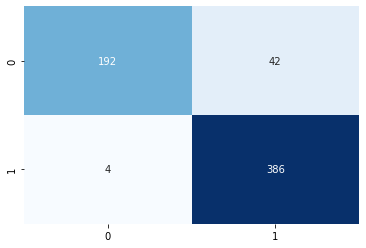

In [35]:
# 混同行列の作成と可視化
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, 
            annot=True, # 数字を表示
            fmt='d', # 整数表示
            cmap='Blues',
            cbar=False # カラーバーを非表示
)
plt.show()

## 正解率

正解率（accuracy）は、すべてのサンプルのうち正解したサンプルの割合

In [36]:
print(accuracy_score(y_true, y_pred))

0.9262820512820513


## 適合率

適合率（precision）は、陽性と予測されたサンプルのうち正解したサンプルの割合

In [37]:
print(precision_score(y_true, y_pred))

0.9018691588785047


## 再現率

再現率（recall）は実際に陽性のサンプルのうち正解したサンプルの割合。sensitivityやhit rate, TPR（true positive rate, 真陽性率）などとも呼ばれる。

In [38]:
print(recall_score(y_true, y_pred))

0.9897435897435898


## 特異度

特異度（specificity）は実際に陰性のサンプルのうち正解したサンプルの割合

In [39]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [40]:
print(tn / (tn + fp))

0.8205128205128205


## F1値

F1値（F1-measure）は適合率と再現率の調和平均。

In [41]:
print(f1_score(y_true, y_pred))

0.9437652811735943


# 予測データフレームの結合・出力

In [42]:
df = pd.concat([test_normal_df, test_pneumonia_df])
df['label'] = df['label'].map({0: 'NORMAL',
                               1: 'PNEUMONIA'})
print(df)

                            name      label
0      NORMAL2-IM-0336-0001.jpeg     NORMAL
1              IM-0101-0001.jpeg     NORMAL
2      NORMAL2-IM-0337-0001.jpeg     NORMAL
3      NORMAL2-IM-0198-0001.jpeg  PNEUMONIA
4              IM-0013-0001.jpeg     NORMAL
..                           ...        ...
385   person1659_virus_2867.jpeg  PNEUMONIA
386   person1615_virus_2801.jpeg  PNEUMONIA
387   person1664_virus_2877.jpeg  PNEUMONIA
388  person111_bacteria_536.jpeg  PNEUMONIA
389  person152_bacteria_724.jpeg  PNEUMONIA

[624 rows x 2 columns]


In [43]:
# データフレームの出力
df.to_csv('/kaggle/working/submission.csv', index = False)